In [30]:
%matplotlib inline
import cv2
import os
import numpy as np
import keras
import matplotlib.pyplot as plt
# import download
from random import shuffle
from tensorflow.keras.applications import VGG16
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Activation
import sys
import h5py
import pandas as pd
import os.path
from pathlib import Path
import math
from keras.models import load_model
import tensorflow as tf
from IPython.display import HTML
import seaborn as sns
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.datasets import make_classification
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

In [28]:
class ViolenceDetection:
    def __init__(self,list_clases):
        # Number of classes for classification (Violence-No Violence)
        self.list_clases=list_clases
        
    def get_frames(self,current_dir, file_name):
        '''
        Function used to get 20 frames from a video file and convert the frame to a suitable format for the neural network.
        '''
        in_file, images  = os.path.join(current_dir, file_name), []
        video_capture = cv2.VideoCapture(in_file)
        success,image = video_capture.read()
        for i in range(20):   
            RGB_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            res = cv2.resize(RGB_img, dsize=(224, 224),interpolation=cv2.INTER_CUBIC)
            images.append(res)
            success,image = video_capture.read()
        result = (np.array(images) / 255.).astype(np.float16)
        return result
    
    def label_video_names(self,in_dir):
        '''
        Function that receives the amount of data downloaded and labels it
        '''
        # list containing video names, list containin video labels [1, 0] if it has violence and [0, 1] if not
        names, labels = [], []    
        for current_dir, dir_names,file_names in os.walk(in_dir):
            for file_name in file_names:
                if file_name[0:2] == 'no':
                    labels.append([0,1])
                else:
                    labels.append([1,0])
                names.append(file_name)
        data = list(zip(names,labels))
        # Suffle the data (names and labels)
        shuffle(data)
        names, labels = zip(*data)
        return names, labels
    
    
    def get_transfer_values(self,current_dir, file_name):
        '''
        Function to process 20 video frames through VGG16 and get transfer values.
        '''
        image_batch = self.get_frames(current_dir, file_name)
        # Pre-allocate output-array for transfer-values.
        # Use 16-bit floating-points to save memory.
        shape = (20, transfer_values_size)
        transfer_values = np.zeros(shape=shape, dtype=np.float16)
        transfer_values = \
        image_model_transfer.predict(image_batch)
        return transfer_values
    
    
    def get_transfer(self,image_model):
        # Use the output of the layer prior to the final
        # classification-layer which is named fc2. This is a fully-connected (or dense) layer.
        transfer_layer = image_model.get_layer('fc2')
        image_model_transfer = Model(inputs=image_model.input,outputs=transfer_layer.output)
        transfer_values_size = K.int_shape(transfer_layer.output)[1]
        return image_model_transfer, transfer_values_size
    
    def proces_transfer(self,vid_names, in_dir, labels):
        '''
        Generator that process one video through VGG16 each function call.
        '''
        for count in range(len(vid_names)):
            video_name = vid_names[count]    
            image_batch = self.get_frames(in_dir, video_name)
            shape = (20, transfer_values_size)
            transfer_values = np.zeros(shape=shape, dtype=np.float16) 
            transfer_values = \
            image_model_transfer.predict(image_batch)
            yield transfer_values, labels[count] *np.ones([20,2])
    
    def make_files(self,n_files, file_name_h5py):
        '''
        Define functions to get the transfer values from VGG16 with defined number of files. 
        Save the transfer values files used from training in one file and the ones uses for testing in another one.
        '''
        gen, numer = self.proces_transfer(names_training, in_dir, labels_training), 1
        # Read the first chunk to get the column dtypes
        chunk = next(gen)
        row_count, row_count2 = chunk[0].shape[0], chunk[1].shape[0]
        with h5py.File(file_name_h5py, 'w') as f:
            # Initialize a resizable dataset to hold the output
            maxshape, maxshape2 = (None,) + chunk[0].shape[1:], (None,) + chunk[1].shape[1:]
            dset = f.create_dataset('data', shape=chunk[0].shape, maxshape=maxshape,chunks=chunk[0].shape, dtype=chunk[0].dtype)
            dset2 = f.create_dataset('labels', shape=chunk[1].shape, maxshape=maxshape2, chunks=chunk[1].shape, dtype=chunk[1].dtype)

            # Write the first chunk of rows
            dset[:] = chunk[0]
            dset2[:] = chunk[1]
            for chunk in gen:
                if numer == n_files:
                    break
                # Resize the dataset to accommodate the next chunk of rows
                dset.resize(row_count + chunk[0].shape[0], axis=0)
                dset2.resize(row_count2 + chunk[1].shape[0], axis=0)
                # Write the next chunk
                dset[row_count:] = chunk[0]
                dset2[row_count:] = chunk[1]
                # Increment the row count
                row_count += chunk[0].shape[0]
                row_count2 += chunk[1].shape[0]
                numer += 1
                
    def process_all_data(self,file_name_h5py):
        '''
        Load the cached transfer values into memory
        '''
        joint_transfer, count=[],0
        with h5py.File(file_name_h5py, 'r') as f:
            X_batch = f['data'][:]
            y_batch = f['labels'][:]
        for i in range(int(len(X_batch)/20)):
            inc = count+20
            joint_transfer.append([X_batch[count:inc],y_batch[count]])
            count =inc
        data, target=[], []
        for i in joint_transfer:
            data.append(i[0])
            target.append(np.array(i[1]))

        return data, target
    
    
    def get_model(self):
        # Defining the Sequential model
        model = Sequential()
        #Adding up the layers of the network
        model.add(LSTM(512, input_shape=(20, 4096)))
        model.add(Dense(1024))
        model.add(Activation('relu'))
        model.add(Dense(50))
        model.add(Activation('sigmoid'))
        model.add(Dense(2))
        model.add(Activation('softmax'))
        #Cmpiling the model
        model.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])
        return model
    
    def fit_model(self,model):
        # This callback allows you to specify the performance measure to monitor, the trigger, and once triggered, it will stop the training process.
        # The "monitor" allows you to specify the performance measure to monitor in order to end training. 
        Callback_Stop_Early = tf.keras.callbacks.EarlyStopping(monitor="loss",patience=3)
        # Fit model
        history = model.fit(np.array(data[0:720]), np.array(target[0:720]), callbacks=Callback_Stop_Early, epochs=200, validation_data=(np.array(data[720:]), np.array(target[720:])),  batch_size=500, verbose=2)
        return history
        
    def save_model(self,history, model):
        np.save('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_violence_video_history.npy',history.history)
        model.save('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_violence_video_model.h5')     
    
    def load_models(self):
        model = load_model('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_violence_video_model.h5')
        history=np.load('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_violence_video_history.npy',allow_pickle='TRUE').item()
        return model, history
    
    def show(self,history,name):
        # summarize history for accuracy and loss
        plt.plot(history[name])
        plt.plot(history['val_'+ name])
        plt.title('model '+ name)
        plt.ylabel(name)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.savefig('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/'+ name +'.png')
        plt.show()   
    
    def evaluate(self,model,data_test,target_test):
        # Calculating a model evaluation
        result = model.evaluate(np.array(data_test), np.array(target_test))
        # Calculating a model prediction
        pred = model.predict(np.array(data_test))
        # Convert the target test vector to a binary list
        df=pd.DataFrame([target_test]).T.astype('str')
        binary_target=df[0].replace('[1. 0.]',1).replace('[0. 1.]',0).values.tolist()
        # Convert the prediction vector to a binary list
        binary_predictions = [0 if i[1] >=0.5 else 1 for i in pred]
        # Result of the model classification indices
        print("Accuracy Classifier: {}%".format(round(accuracy_score(binary_predictions, binary_target)*100,2)))
        print(classification_report(binary_predictions, binary_target))
        # show confusion_matrix polit
        cm=confusion_matrix(binary_predictions, binary_target)
        plt.figure(figsize=(6,6))
        sns.heatmap(cm, annot=True, fmt='d', xticklabels=['FAKE', 'TRUE'], yticklabels=['FAKE', 'TRUE'], cmap=plt.cm.Oranges, cbar=False)
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.title('CNN+LSTM')
        plt.savefig('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/CNN+LSTM.png')
        plt.show()

    def check_test(self,data_test):
        # A function that returns the test prediction
        prediction = model.predict(np.array(data_test))
        queue=[]
        queue.append(prediction)
        results = np.array(queue).mean(axis=1)
        print(results)
        predict_class = self.list_clases[np.argmax(results)]
        print('Test prediction is: ',predict_class)

        
    def check_vedio(self,in_dir, name_vedio):
        # Function that returns to a specific video. Is there violence and non-violence
        vec_transfer= self.get_transfer_values(in_dir,name_vedio)
        vec_test, queue=[], []
        vec_test.append(vec_transfer)
        # Prediction of the video
        prediction = model.predict(np.array(np.array(vec_test)))
        # The result of the prediction by class
        queue.append(prediction)
        results = np.array(queue).mean(axis=1)
        predict_class = self.list_clases[np.argmax(results)]
        # Create a data frame with the results
        temp_data=prediction.flatten().tolist()
        temp_data.append(predict_class)
        df_res= pd.DataFrame([temp_data], columns=['NonViolence','Violence', 'prediction'])
        df_res=df_res.rename(index={0: "result"})
        return df_res
    

In [31]:
#Number of classes for classification 
list_clases=['NonViolence', 'Violence']
obj=ViolenceDetection(list_clases)
#Define the directory to place the video dataset
in_dir = "/content/drive/MyDrive/Group12_Violence_detection_projectAI/dataset_video/"
# Get the names and labels of the whole videos
names, labels = obj.label_video_names(in_dir)

In [32]:
# list containing video names
names[:1000]

('fi31_xvid.avi',
 'fi146_xvid.avi',
 'no181_xvid.avi',
 'no107_xvid.avi',
 'fi458_xvid.avi',
 'no472_xvid.avi',
 'fi356_xvid.avi',
 'fi468_xvid.avi',
 'fi422_xvid.avi',
 'fi342_xvid.avi',
 'fi275_xvid.avi',
 'fi177_xvid.avi',
 'no230_xvid.avi',
 'fi35_xvid.avi',
 'no427_xvid.avi',
 'fi267_xvid.avi',
 'fi124_xvid.avi',
 'fi252_xvid.avi',
 'no306_xvid.avi',
 'no135_xvid.avi',
 'fi276_xvid.avi',
 'no346_xvid.avi',
 'no318_xvid.avi',
 'no439_xvid.avi',
 'fi334_xvid.avi',
 'no184_xvid.avi',
 'fi463_xvid.avi',
 'fi291_xvid.avi',
 'no458_xvid.avi',
 'fi235_xvid.avi',
 'fi180_xvid.avi',
 'no50_xvid.avi',
 'no274_xvid.avi',
 'no418_xvid.avi',
 'fi236_xvid.avi',
 'fi346_xvid.avi',
 'no154_xvid.avi',
 'fi33_xvid.avi',
 'no285_xvid.avi',
 'fi486_xvid.avi',
 'no302_xvid.avi',
 'fi173_xvid.avi',
 'no191_xvid.avi',
 'fi223_xvid.avi',
 'fi74_xvid.avi',
 'no414_xvid.avi',
 'fi273_xvid.avi',
 'fi194_xvid.avi',
 'fi170_xvid.avi',
 'fi27_xvid.avi',
 'no396_xvid.avi',
 'no252_xvid.avi',
 'no425_xvid.avi',

In [33]:
#list containin video labels [1, 0] if it has violence and [0, 1] if not
labels[:1000]

([1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [0, 1],
 [1, 0],
 [1, 0],
 [1, 0],
 [0, 1],
 [0, 1],
 [0, 1],
 [1, 0],
 [1, 0],
 [0, 1],
 [1, 0],
 

In [34]:
# Pretrained model: VGG16
# Create an instance of the pre-trained VGG16 model
image_model = VGG16(include_top=True, weights='imagenet')
# Printing out the image_model summary
image_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [35]:
image_model_transfer, transfer_values_size= obj.get_transfer(image_model)

In [36]:
# Split the dataset into training set and test set
training_set = int(len(names)*0.8)
test_set = int(len(names)*0.2)
# Perform division into train and test of names
names_training = names[0:training_set]
names_test = names[training_set:]
# Perform division into train and test of labels
labels_training = labels[0:training_set]
labels_test = labels[training_set:]

In [37]:
# Process all video frames through VGG16 and save the transfer values.
obj.make_files(training_set, '/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_train.h5')
obj.make_files(test_set, '/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_test.h5')

In [38]:
# Load the cached transfer values into memory
data, target = obj.process_all_data('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_train.h5')
data_test, target_test = obj.process_all_data('/content/drive/MyDrive/Group12_Violence_detection_projectAI/data/Group12_test.h5')

In [39]:
model=obj.get_model()
history=obj.fit_model(model)
obj.save_model(history, model)
model, history=obj.load_models()
#Printing out the model summary
model.summary()

Epoch 1/200
2/2 - 2s - loss: 0.6997 - accuracy: 0.4931 - val_loss: 0.7342 - val_accuracy: 0.4875 - 2s/epoch - 1s/step
Epoch 2/200
2/2 - 0s - loss: 0.7127 - accuracy: 0.5097 - val_loss: 0.6822 - val_accuracy: 0.8750 - 334ms/epoch - 167ms/step
Epoch 3/200
2/2 - 0s - loss: 0.6786 - accuracy: 0.7653 - val_loss: 0.6619 - val_accuracy: 0.8750 - 301ms/epoch - 150ms/step
Epoch 4/200
2/2 - 0s - loss: 0.6470 - accuracy: 0.8792 - val_loss: 0.6241 - val_accuracy: 0.9000 - 300ms/epoch - 150ms/step
Epoch 5/200
2/2 - 0s - loss: 0.6005 - accuracy: 0.8750 - val_loss: 0.5786 - val_accuracy: 0.6625 - 299ms/epoch - 150ms/step
Epoch 6/200
2/2 - 0s - loss: 0.5506 - accuracy: 0.7944 - val_loss: 0.5582 - val_accuracy: 0.7250 - 296ms/epoch - 148ms/step
Epoch 7/200
2/2 - 0s - loss: 0.5041 - accuracy: 0.8403 - val_loss: 0.5018 - val_accuracy: 0.7875 - 306ms/epoch - 153ms/step
Epoch 8/200
2/2 - 0s - loss: 0.4491 - accuracy: 0.8500 - val_loss: 0.4272 - val_accuracy: 0.8625 - 296ms/epoch - 148ms/step
Epoch 9/200
2/

In [40]:
obj.check_test(data_test)

[[0.49522424 0.50477576]]
Test prediction is:  Violence


7/7 [==============================] - 0s 13ms/step - loss: 0.1984 - accuracy: 0.9500
Accuracy Classifier: 95.0%
              precision    recall  f1-score   support

           0       0.98      0.92      0.95        97
           1       0.93      0.98      0.95       103

    accuracy                           0.95       200
   macro avg       0.95      0.95      0.95       200
weighted avg       0.95      0.95      0.95       200



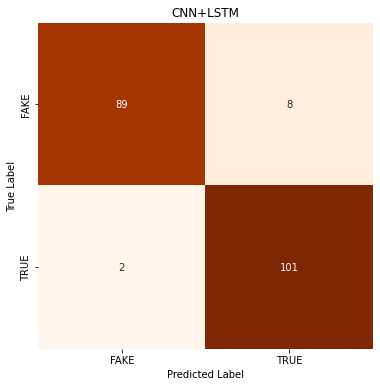

In [41]:
obj.evaluate(model,data_test,target_test)

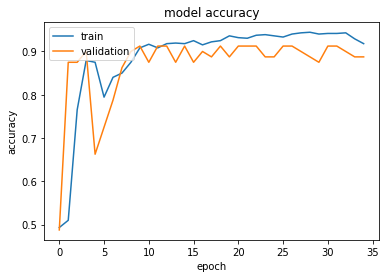

In [42]:
# summarize history for accuracy
obj.show(history,'accuracy')

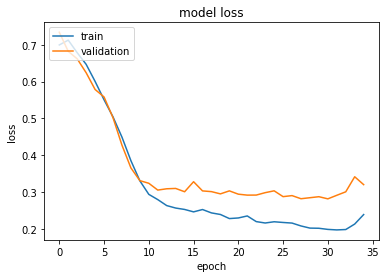

In [43]:
# summarize history for loss
obj.show(history,'loss')